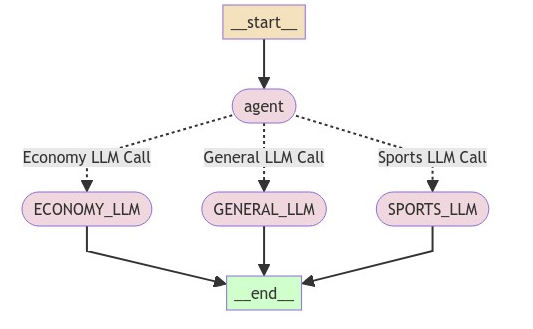


In [3]:
import os
from crewai import Agent, Task, Crew, Process
from langchain.tools import DuckDuckGoSearchRun
from langchain_openai import AzureChatOpenAI
search_tool = DuckDuckGoSearchRun()
from dotenv import load_dotenv
load_dotenv()

True

In [55]:
from langchain_community.llms import Ollama

llm = Ollama(
    model="mistral"
)  # assuming you have Ollama installed and have llama3 model pulled with `ollama pull llama3 `


In [56]:
#llm = AzureChatOpenAI(temperature = 0, model = "gpt-35-turbo-16k")

In [66]:
llm.invoke('Hi')

" Hello! How can I help you today? Is there something specific you would like to know or discuss? I'm here to provide information and answer any questions you might have.\n\nIf you need help with a particular topic, or if you just want to chat about something interesting, feel free to ask! I'll do my best to assist you in any way that I can.\n\nIs there anything on your mind today?"

In [58]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Making Complex Graphs with Conditional Edges

In [59]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate


class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    #Reasoning: str = Field(description='Reasoning behind topic selection')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

## Topic Selector

In [60]:
def function_1(state):
    print('-> Calling Agent ->')
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    
    templete = """ Your task is to provide only the topic based on the user query. 
        Only output the topic among: [Eonomy,Sports,General]. Don't include reasoning. 
        Following is the user query:  {question}
        {format_instructions} """
    
    prompt = PromptTemplate(template=templete,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain = prompt | llm | parser

    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [61]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'economy' in last_message:
        return 'Economy LLM Call'
    elif 'sports' in last_message:
        return 'Sports LLM Call'
    else:
        return 'General LLM Call'

In [75]:
def function_2(state):
    print('-> Calling Economy LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "You are an Expert in Finanace & Economy. Anwer the follow question with your economic knowledge. Following is the user question: " + question
    response = llm.invoke(complete_query)
    print(response)
    return {"messages": [str(response)]}

def function_3(state):
    print('-> Calling Sports LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "You are an Expert in Sports knowledge. Anwer the follow question with your latest sports knowledge. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [str(response)]}


def function_4(state):
    print('-> Calling General LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [str(response)]}

### Generating the Graph by adding Nodes & Edges

In [76]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("agent", function_1)
graph.add_node("ECONOMY_LLM", function_2)
graph.add_node("SPORTS_LLM", function_3)
graph.add_node("GENERAL_LLM", function_4)

graph.set_entry_point("agent")


# conditional edges are controlled by our router
graph.add_conditional_edges(
    source="agent",  # where in graph to start
    path=router,  # function to determine which node is called
    path_map={
        "Economy LLM Call": "ECONOMY_LLM",
        "Sports LLM Call": "SPORTS_LLM",
        "General LLM Call": "GENERAL_LLM"
    }
)

graph.add_edge("ECONOMY_LLM", END)
graph.add_edge("SPORTS_LLM", END)
graph.add_edge("GENERAL_LLM", END)


app = graph.compile()

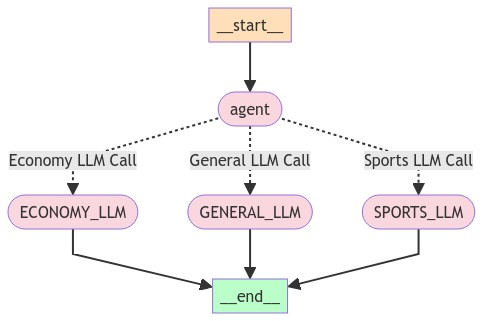

In [77]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

### Sample Questions

In [78]:
inputs = {"messages": ["Who won the ICC Cricket World Cup on 2011?"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='Sports'
-> Router ->
Sports
-> Calling General LLM ->


In [79]:
out['messages']

['Who won the ICC Cricket World Cup on 2011?',
 'Sports',
 ' The ICC Cricket World Cup in 2011 was won by India. They defeated Sri Lanka in the final match held at the Wankhede Stadium, Mumbai, India, on April 2, 2011. The Man of the Match was Yuvraj Singh for his all-round performance.']

#### Sports Related Question

In [80]:
inputs = {"messages": ["Who came fourth for Ireland at the outdoor European Running Championships in 1998?"]}
out = app.invoke(inputs)
print(out)

-> Calling Agent ->
Topic='Sports'
-> Router ->
Sports
-> Calling General LLM ->
{'messages': ['Who came fourth for Ireland at the outdoor European Running Championships in 1998?', 'Sports', ' To provide an accurate answer, I would need to access a comprehensive database of sports results from that era. However, without specific data sources, I cannot confidently state who came fourth for Ireland at the 1998 European Athletics Championships in running events. It is recommended to consult reliable sources like the official website of the European Athletics Association or online archives for detailed information on past championships.']}


#### Ecomony Related Question

In [81]:
inputs = {"messages": ["What is the GDP Growth perchentage of India from Independence?"]}
out = app.invoke(inputs)
print(out)

-> Calling Agent ->
Topic='Eonomy'
-> Router ->
Eonomy
-> Calling General LLM ->
{'messages': ['What is the GDP Growth perchentage of India from Independence?', 'Eonomy', " To provide an accurate answer, I would need specific years for reference since India gained independence in 1947 and GDP data starts from different years for different sources. However, I can give you a general idea about India's GDP growth over the past few decades.\n\nAccording to the World Bank Data, India's annual GDP growth rate fluctuated significantly during the post-independence period:\n1. The 1950s and early 1960s saw average growth rates of around 3.5%.\n2. In the late 1960s and 1970s, economic growth slowed down to less than 3%.\n3. The 1980s witnessed an improvement in GDP growth, with an average rate of about 5.5%.\n4. In the 1990s, India's economy experienced rapid growth, with annual rates averaging around 6%.\n5. The early 21st century has seen a consistent growth rate of approximately 7%.\n\nThe ex

#### General Question (Not Specified)

In [82]:
inputs = {"messages": ["How many Attention Blocks are in BERT Transformer?"]}
out = app.invoke(inputs)
print(out)

-> Calling Agent ->
Topic='General'
-> Router ->
General
-> Calling General LLM ->
{'messages': ['How many Attention Blocks are in BERT Transformer?', 'General', " In the original BERT (Bidirectional Encoder Representations from Transformers) model, there's no specific number of Attention blocks specified because it uses a stack of 12 layers, each containing two sub-layers: an encoder block and a decoder block. Each encoder block has a self-attention mechanism followed by a feed-forward neural network (FFN), which includes another attention mechanism known as the Multi-Head Attention (MHA) in this case. However, it's essential to note that the number of layers can vary depending on the specific BERT model version you are referring to. For instance, BERT base has 12 layers, while BERT large has 24 layers. So, there are multiple Attention blocks in a BERT Transformer, but the exact count would depend on the number of layers in your chosen BERT version."]}
